In [12]:
from xgboost import XGBRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import warnings
from acpi.utils import compute_coverage
from acpi import ACPI


warnings.filterwarnings("ignore")

test_ratio = 0.25
calibration_ratio = 0.5
alpha = 0.1

sklearn_data = fetch_california_housing()
X, y = sklearn_data.data, sklearn_data.target


In [13]:
res = []
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio)
    x_train, x_cal, y_train, y_cal = train_test_split(x_train, y_train, test_size=calibration_ratio)
    model = XGBRegressor()
    model.fit(x_train, y_train)

    # It has the same params as a Random Forest, and it should be tuned to predict the score of calibration set.
    acpi = ACPI(model_cali=model, n_estimators=100, max_depth=20, min_node_size=10)

    acpi.fit(x_cal, y_cal, nonconformity_func=None)
    # You can use custom nonconformity score by using the argument 'nonconformity_func'.
    # It takes a callable[[ndarray, ndarray], ndarray] that return the nonconformity
    # score given (predictions, y_true). By the default, it uses absolute residual if the model
    # is mean estimates and max(pred_lower - y, y - pred_upper) if the model is quantile estimates.

    v_cal = acpi.nonconformity_score(model.predict(x_cal), y_cal)

    acpi.fit_calibration(x_cal, y_cal, nonconformity_func=None, quantile=1-alpha, only_qrf=True)
    y_lower, y_upper = acpi.predict_pi(x_test, method='qrf')


    coverage_qrf = compute_coverage(
        y_test,
        y_lower,
        y_upper)

    res.append(coverage_qrf)
    print(f'Coverage QRF at {i} = ', coverage_qrf)

100%|██████████| 50/50 [03:41<00:00,  4.44s/it]


Coverage QRF at 0 =  0.8887596899224807


100%|██████████| 50/50 [03:48<00:00,  4.58s/it]


Coverage QRF at 1 =  0.8959302325581395


100%|██████████| 50/50 [04:02<00:00,  4.85s/it]


Coverage QRF at 2 =  0.9025193798449612


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


Coverage QRF at 3 =  0.8922480620155039


100%|██████████| 50/50 [04:03<00:00,  4.86s/it]


Coverage QRF at 4 =  0.8996124031007752


100%|██████████| 50/50 [03:56<00:00,  4.73s/it]


Coverage QRF at 5 =  0.8965116279069767


100%|██████████| 50/50 [04:03<00:00,  4.87s/it]


Coverage QRF at 6 =  0.8936046511627908


100%|██████████| 50/50 [03:53<00:00,  4.68s/it]


Coverage QRF at 7 =  0.9003875968992248


100%|██████████| 50/50 [03:45<00:00,  4.50s/it]


Coverage QRF at 8 =  0.8959302325581395


100%|██████████| 50/50 [03:30<00:00,  4.20s/it]


Coverage QRF at 9 =  0.9038759689922481


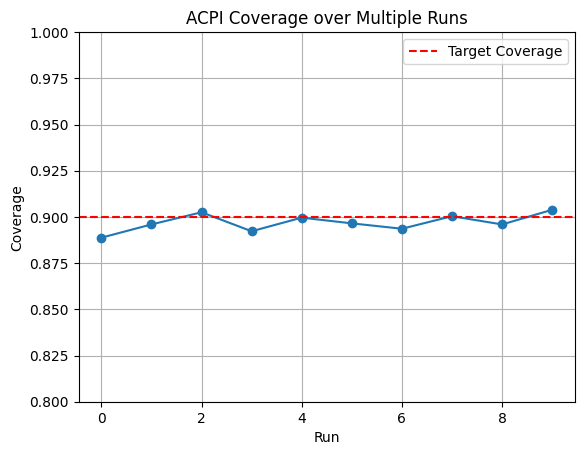

In [14]:
# plot the results
import matplotlib.pyplot as plt
plt.plot(range(10), res, marker='o')
plt.axhline(y=1-alpha, color='r', linestyle='--', label='Target Coverage')
plt.title('ACPI Coverage over Multiple Runs')
plt.xlabel('Run')
plt.ylabel('Coverage')
plt.ylim(0.8, 1)
plt.legend()
plt.grid()
plt.show()
